In [104]:
import jax.numpy as jnp
import liesel.model as lsl
import numpy as np
import pandas as pd
from formulaic import ModelSpec

from liesel_gam import Basis

In [ ]:
class FormulaicBasisBuilder:
    def __init__(self, data):
        self.data = data.copy()
        self.map_funs = dict()
        self.mappings = dict()

        self._make_categorical_series_numeric()  # fills self.map_funs and self.mappings

    @staticmethod
    def is_categorical(series: pd.Series) -> bool:
        is_cat1 = series.dtype in ("str", "object")
        is_cat2 = isinstance(series.dtype, pd.CategoricalDtype)
        return is_cat1 or is_cat2

    @staticmethod
    def setup_index_map(series: pd.Series):
        x = series.to_numpy()
        unique_labels = np.unique(x)
        mapping = {val: i for i, val in enumerate(unique_labels)}
        lookup = np.frompyfunc(lambda x: mapping.get(x, -1), 1, 1)

        def map_fun(x):
            return np.asarray(lookup(x), dtype=int)

        return mapping, map_fun

    def _make_categorical_series_numeric(self):
        for col in self.data:
            series = self.data[col]
            if not self.is_categorical(series):
                continue

            mapping, map_fun = self.setup_index_map(series)
            self.map_funs[col] = map_fun
            self.mappings[col] = mapping

            self.data[col] = map_fun(series.to_numpy())

    def basis(
        self, formula: str, name: str = "X", include_intercept: bool = False
    ) -> Basis:
        """
        General basis-generation.
        Intended mostly for simple linear effects and interactions, and categorical
        effects.
        """
        spec = ModelSpec(formula, ensure_full_rank=True, output="numpy")
        required = sorted(str(var) for var in spec.required_variables)
        df_subset = self.data.loc[:, required]
        df_colnames = df_subset.columns

        variables = dict()

        for col in df_colnames:
            variables[col] = lsl.Var.new_obs(self.data[col].to_numpy(), name=col)

        xvar = lsl.TransientCalc(  # for memory-efficiency
            lambda *args: jnp.vstack(args).T,
            *list(variables.values()),
            _name=name + "_tcalc",
        )

        def basis_fn(x):
            df = pd.DataFrame(x, columns=df_colnames)
            basis = np.asarray(spec.get_model_matrix(df))
            if not include_intercept:
                basis = basis[:, 1:]
            return jnp.asarray(basis, dtype=float)

        basis = Basis(xvar, basis_fn=basis_fn, name=name)

        return basis

    def ri(self, name: str) -> Basis:
        """Random intercept basis."""
        spec = ModelSpec(f"-1 + C({name})", ensure_full_rank=True, output="numpy")
        xvar = lsl.Var.new_obs(self.data[name].to_numpy(), name=name)

        def basis_fn(x):
            df = pd.DataFrame(x, columns=[name])
            basis = np.asarray(spec.get_model_matrix(df))
            return jnp.asarray(basis, dtype=float)

        basis = Basis(xvar, basis_fn=basis_fn)

        return basis

    def rs(self, name: str, cluster: str) -> Basis:
        """Random slope basis."""
        spec = ModelSpec(
            f"-1 + {name} : (-1 + C({cluster}))", ensure_full_rank=True, output="numpy"
        )
        xvar = lsl.Var.new_obs(self.data[name].to_numpy(), name=name)
        clustervar = lsl.Var.new_obs(self.data[cluster].to_numpy(), name=cluster)
        cluster_name = cluster

        def basis_fn(x, cluster):
            df = pd.DataFrame(np.vstack((x, cluster)).T, columns=[name, cluster_name])
            basis = np.asarray(spec.get_model_matrix(df))
            return jnp.asarray(basis, dtype=float)

        basis = Basis(
            xvar,
            basis_fn=basis_fn,
            cluster=clustervar,
            name=f"B({name}, {cluster_name})",
        )

        return basis

    def process_newdata(self, newdata: dict):
        # replace categorical inputs with their index representation
        # create combined input matrices from individual variables, if desired
        newdata = newdata.copy()

        # replace categorical variables by their integer representations
        for name, map_fun in self.map_funs.items():
            if name in newdata:
                newdata[name] = map_fun(newdata[name])

        return newdata


In [119]:
df = pd.DataFrame(
    {"x1": [1, 2, 3], "x2": [10, 20, 30], "x3": [10, 20, 30], "g": ["a", "a", "b"]}
)
fb = FormulaicBasisBuilder(df)

[[1. 0. 0.]
 [2. 0. 0.]
 [3. 1. 3.]]


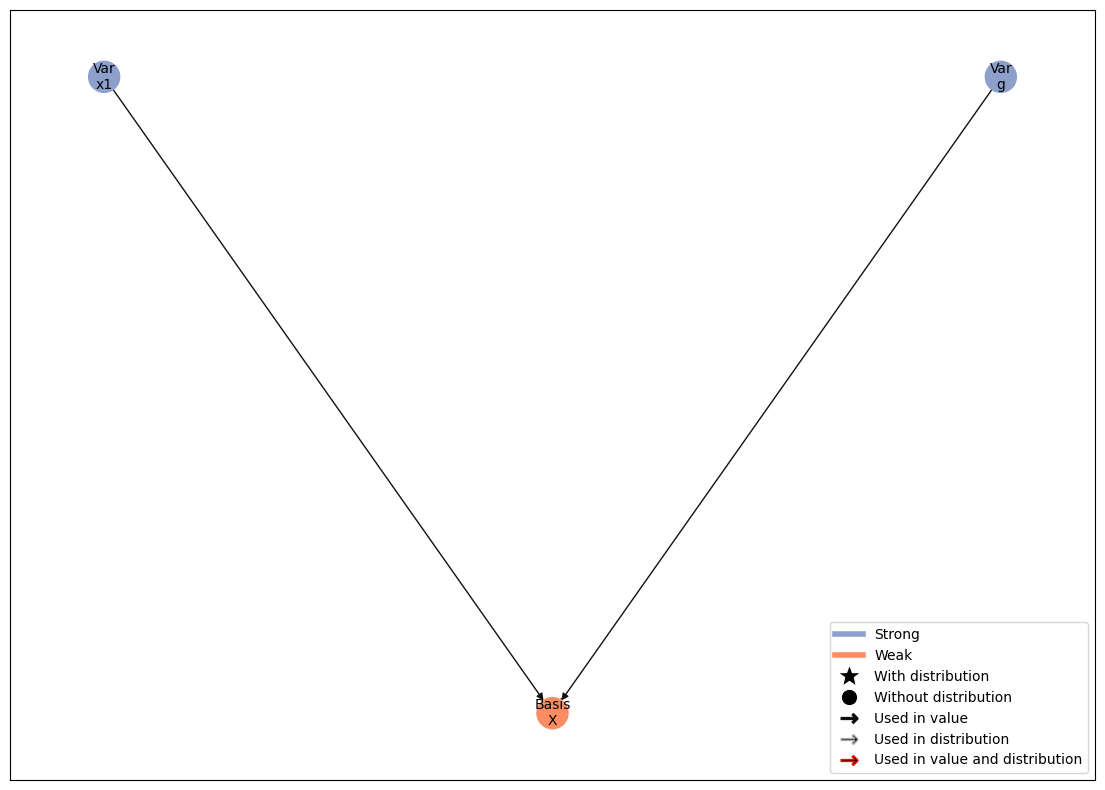

In [125]:
b1 = fb.basis("x1*C(g)", name="X")
print(b1.value)
b1.plot_vars()

[[1. 0.]
 [1. 0.]
 [0. 1.]]


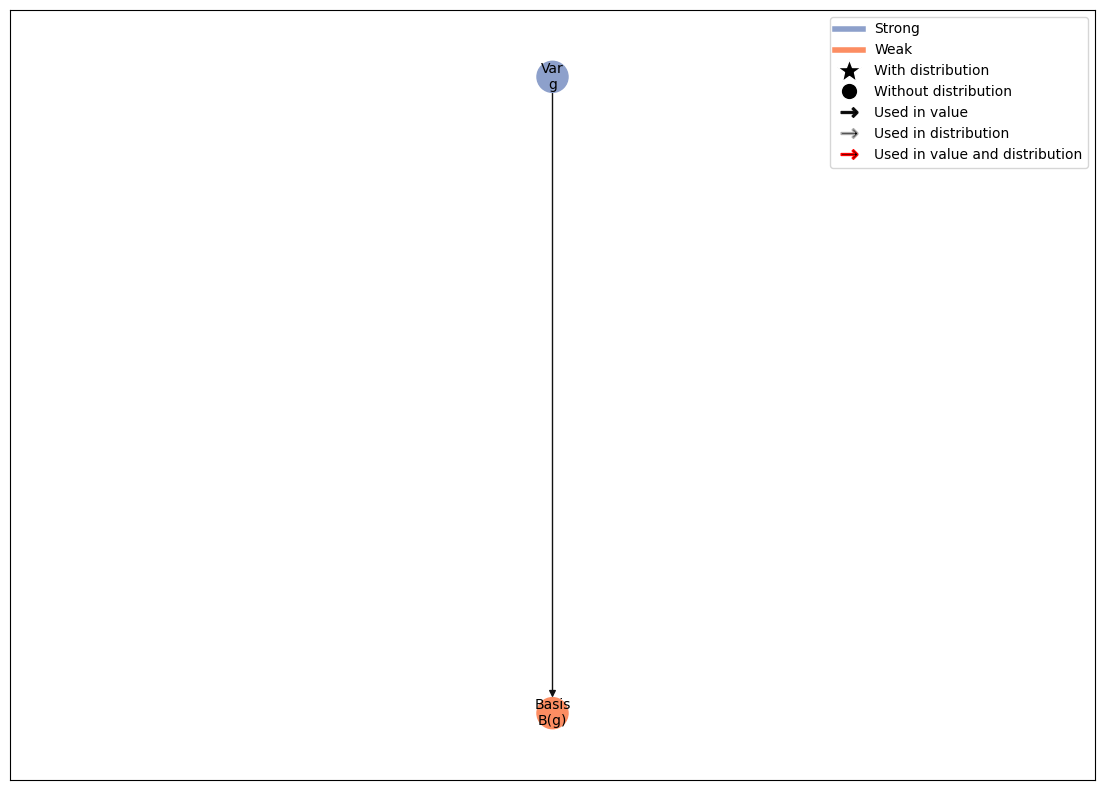

In [108]:
b2 = fb.ri("g")
print(b2.value)
b2.plot_vars()

[[1. 0.]
 [2. 0.]
 [0. 3.]]


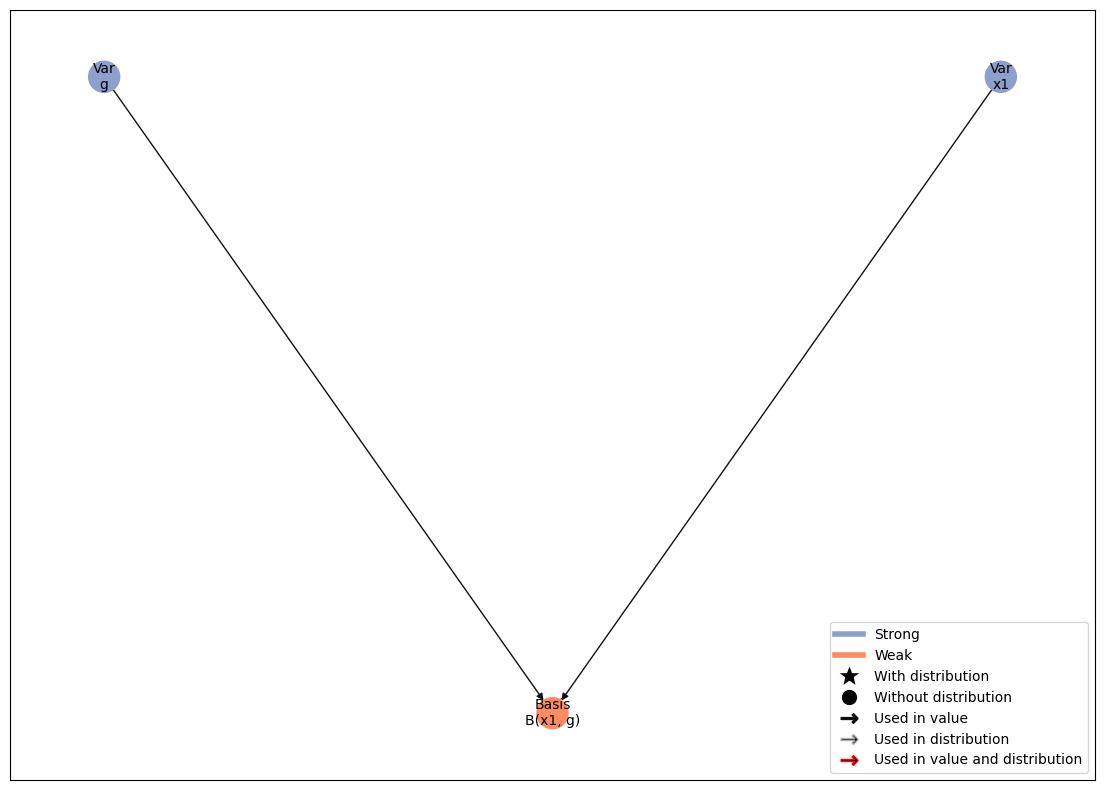

In [109]:
b3 = fb.rs("x1", "g")
print(b3.value)
b3.plot_vars()

[[ 1.]
 [ 1.]
 [-1.]]


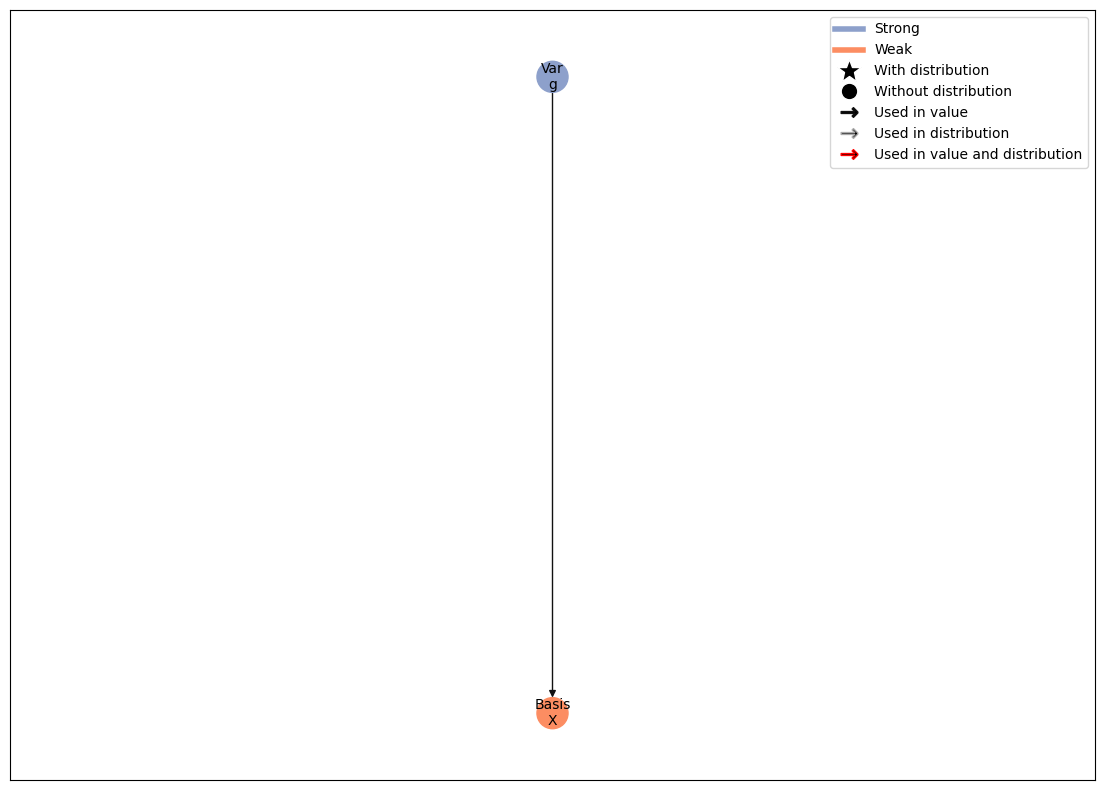

In [123]:
b = fb.basis("C(g, contr.sum)", name="X")
print(b.value)
b.plot_vars()

In [ ]:
df = pd.DataFrame({"g": ["a", "a", "b", "c", "d"]})
fb = FormulaicBasisBuilder(df)

b = fb.basis("C(g, contr.sum)", name="X")
print(b.value)

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1. -1. -1.]]


In [ ]:
df = pd.DataFrame({"g": ["a", "a", "b", "c", "d"]})
fb = FormulaicBasisBuilder(df)

b = fb.basis("C(g, contr.poly)", name="X")
print(b.value)

[[-0.6708204  0.5       -0.2236068]
 [-0.6708204  0.5       -0.2236068]
 [-0.2236068 -0.5        0.6708204]
 [ 0.2236068 -0.5       -0.6708204]
 [ 0.6708204  0.5        0.2236068]]


In [ ]:
df = pd.DataFrame({"g": ["a", "a", "b", "c", "d"]})
fb = FormulaicBasisBuilder(df)

b = fb.basis("C(g, contr.helmert)", name="X")
print(b.value)

[[-1. -1. -1.]
 [-1. -1. -1.]
 [ 1. -1. -1.]
 [ 0.  2. -1.]
 [ 0.  0.  3.]]


In [ ]:
df = pd.DataFrame({"g": ["a", "a", "b", "c", "d"]})
fb = FormulaicBasisBuilder(df)

ic = fb.map_funs["g"]("c")  # get integer representation of desired base category
b = fb.basis(f"C(g, contr.treatment(base={ic}))", name="X")
print(b.value)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
